In [267]:
import torchio as tio
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, '../../scripts/')
from helpers import miscellaneous as misc
from helpers import plotters
from helpers import preprocessing
CONFIG = misc.get_config()

img_dir = '../../' + CONFIG['FLATTENED_DATA_DIR']

img_ids = os.listdir(img_dir)

In [268]:
DEVICE = CONFIG['DEVICE']
LEARNING_RATE = CONFIG['LEARNING_RATE']
BATCH_SIZE = CONFIG['BATCH_SIZE']
EPOCHS = CONFIG['EPOCHS']
TRANSFORMER = CONFIG['TRANSFORMER']
TRAIN_SET = '../' + CONFIG['TEST_LABELS_DIR']
TEST_SET = '../' + CONFIG['TEST_LABELS_DIR']
RAW_DATA = '../' + CONFIG['FLATTENED_DATA_DIR']
PLOT_DIR = '../' + CONFIG['PLOT_DIR_BINARY']

In [328]:
import torchio as tio
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
import pandas as pd
import os
from sklearn.utils import shuffle

class MRIDataset(Dataset):
    """
    Implements __getitem__ method to get items for batches
    Attributes
    ----------
    image_path (string): Path to the image folder
    test_path (string: Path to where tabular data is stored
    annotation_path (string): path to annotation where label is stored
    transform (object, callable): Optional transform to be applied
        on a sample.
    labels: labels extracted from annotation_path
    images: iterable list of paths to all images (could also be images themselves)
    test_results: test results extracted from test_path
    ----------
    Methods
    ----------
    forward(images): takes images and does forward feed calculation
    """
    def __init__(self, dataset_path, shuffle_ = True, transform=None, nslice=None, dimension=1):
        """
        Parameters:
            image_path (string): Path to the image folder
            test_path (string: Path to where tabular data is stored
            annotation_path (string): path to annotation where label is stored
            transform (object, callable): Optional transform to be applied
                on a sample.
        """
        self.dataset_path = dataset_path
        self.transform = transform
        # fixme should be handled in another way. maybe in configuration file?
        self.idx_to_label = {
            'CN': 0,
            'MCI': 1,
            'AD': 2
        }
        self.nslice=nslice
        self.dimension=dimension
        
        
        self.df = pd.read_csv(self.dataset_path)
        
        if shuffle_ == True:
            self.df = shuffle(self.df)
        
        # fix this while generating train/test split
        self.df.dropna(subset=['filename'], how='all', inplace=True)

    def __len__(self):
        """
        returns amount of images in total
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Parameters:
            idx (int): index to image
        """
        
        #switch case for each individual cognitive test?
        """test_results = self.test_results[["CDMEMORY", "CDORIENT", "CDJUDGE", "CDCOMMUN", "CDHOME", "CDCARE", "CDGLOBAL"]].sample(n=1)
        test_results = torch.from_numpy(test_results.to_numpy().astype(np.float32))"""

        img = tio.ScalarImage('../' + self.df.iloc[idx].filename)
        
        #get image and caption by id
        label = self.df.iloc[idx].Group
        label = self.idx_to_label[label]
        label = nn.functional.one_hot(torch.tensor(label), num_classes = 3).to(torch.float32)
            
        if self.nslice == 'Center':
            self.nslice = img.data.size(self.dimension)//2
            
        if self.nslice:
            if self.dimension == 1:
                assert img.data.size()[1] >= self.nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[1]}'
                img.data = img.data[:, self.nslice, :, :]
            elif self.dimension == 2:
                assert img.data.size()[2] >= self.nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[2]}'
                img = img.data[:, :, self.nslice, :]
            elif self.dimension == 3:
                assert img.data.size()[3] >= self.nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
                img = img.data[:, :, :, self.nslice]
                
        if self.transform is not None:
            img = self.transform(img)

        return {"images": img.data, "labels": label } #, test_results

In [329]:
data= MRIDataset(dataset_path='../' + TRAIN_SET, transform=None, nslice='Center', dimension=2)

In [330]:
dataloader = DataLoader(data, batch_size=2, shuffle=True)


In [333]:
# Display image and label.
result = next(iter(dataloader))
train_features, train_labels = result['images'], result['labels']

In [334]:
train_features.data.size()

torch.Size([2, 1, 256, 166])

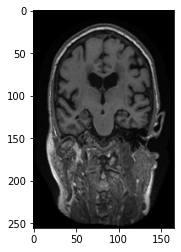

Label: tensor([0., 0., 1.])


In [335]:
# plot 2d
img = train_features.data.squeeze(dim=1)[0]
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")